# Refactor `merge_operator_data`

In [1]:
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd

In [2]:
import _report_visuals_utils
import google.auth
import merge_data
import merge_operator_data
import viz_data_prep
from calitp_data_analysis.sql import to_snakecase
from IPython.display import HTML, Image, Markdown, display, display_html
from merge_data import PORTFOLIO_ORGANIZATIONS_DICT, merge_in_standardized_route_names
from segment_speed_utils import gtfs_schedule_wrangling, helpers, time_series_utils
from segment_speed_utils.project_vars import COMPILED_CACHED_VIEWS, PROJECT_CRS
from shared_utils import (
    catalog_utils,
    dask_utils,
    gtfs_utils_v2,
    portfolio_utils,
    publish_utils,
    rt_dates,
    rt_utils,
)
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS, SCHED_GCS, SEGMENT_GCS

credentials, project = google.auth.default()

In [33]:
from omegaconf import OmegaConf

readable_dict = OmegaConf.load("readable2.yml")

In [5]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [6]:
analysis_date_list = rt_dates.y2024_dates

## Recreate old charts and maps `aggregate_filter_operator_dates.py`
* Use `operator_profiles_recent.parquet` and `operator_routes.parquet`
* Use <i>Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)</i>

In [7]:
OPERATOR_PROFILE = GTFS_DATA_DICT.digest_tables.operator_profiles

In [8]:
op_profile_ntd = pd.read_parquet(f"{RT_SCHED_GCS}{OPERATOR_PROFILE}_recent.parquet")

In [9]:
f"{RT_SCHED_GCS}{OPERATOR_PROFILE}_recent.parquet"

'gs://calitp-analytics-data/data-analyses/rt_vs_schedule/digest/operator_profiles_recent.parquet'

In [10]:
op_profile_ntd.service_date.unique()

array(['2025-04-16T00:00:00.000000000', '2025-03-12T00:00:00.000000000',
       '2024-03-13T00:00:00.000000000', '2024-12-11T00:00:00.000000000',
       '2024-06-12T00:00:00.000000000'], dtype='datetime64[ns]')

In [11]:
portfolio_name = "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"

In [12]:
ventura_op_profile = op_profile_ntd.loc[
    (
        op_profile_ntd.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

In [14]:
# ventura_op_profile.columns = ventura_op_profile.columns.str.title().str.replace("_", " ")

In [16]:
OPERATOR_ROUTE = GTFS_DATA_DICT.digest_tables.operator_routes_map

In [17]:
op_geography_df = gpd.read_parquet(
    f"{RT_SCHED_GCS}{OPERATOR_ROUTE}.parquet",
    storage_options={"token": credentials.token},
)

In [62]:
op_geography_df.columns

Index(['shape_array_key', 'geometry', 'feed_key', 'schedule_gtfs_dataset_key',
       'route_id', 'direction_id', 'route_key', 'route_length',
       'route_length_miles', 'is_downtown_local', 'is_local', 'is_coverage',
       'is_rapid', 'is_express', 'is_rail', 'is_ferry',
       'organization_source_record_id', 'organization_name', 'service_date',
       'portfolio_organization_name', 'name', 'combined_name',
       'recent_combined_name', 'recent_route_id',
       'route_length_miles_percentile', 'percentile_group',
       'shortest_longest'],
      dtype='object')

In [18]:
ventura_geo = op_geography_df.loc[
    (
        op_geography_df.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

In [19]:
try:
    date = ventura_op_profile["service_date"].dt.to_pydatetime()[0]
except:
    pass

In [20]:
date

datetime.datetime(2025, 4, 16, 0, 0)

In [21]:
service_area = int(ventura_op_profile.service_area_sq_miles.values[0])
service_area = "{:,}".format(service_area)
service_pop = int(ventura_op_profile.service_area_pop.values[0])
service_pop = "{:,}".format(service_pop)

In [22]:
display(
    Markdown(
        f"""{portfolio_name} is headquartered in <b>{ventura_op_profile.hq_city.values[0]}</b> in the Urbanized Area of <b>{ventura_op_profile.primary_uza_name.values[0]}</b>.<br>
            This operator provides <b>{service_area}</b> square miles of public transit service, which has a service population of <b>{service_pop}</b>.<br>
            This organization is a {ventura_op_profile.reporter_type.values[0]}.<br>
            <b>Data Source</b>: <a href="https://www.transit.dot.gov/ntd/data-product/2022-annual-database-agency-information">National Transit Database</a> Annual Agency Information.
            """
    )
)

Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks) is headquartered in <b>Oxnard, Camarillo, Moorpark, Simi Valley, Thousand Oaks</b> in the Urbanized Area of <b>Oxnard--San Buenaventura (Ventura), CA, Thousand Oaks, CA, Camarillo, CA, Simi Valley, CA</b>.<br>
            This operator provides <b>2,527</b> square miles of public transit service, which has a service population of <b>8,653,897</b>.<br>
            This organization is a Reduced Reporter, Full Reporter.<br>
            <b>Data Source</b>: <a href="https://www.transit.dot.gov/ntd/data-product/2022-annual-database-agency-information">National Transit Database</a> Annual Agency Information.
            

## Operator Overview

In [23]:
try:
    display(
        Markdown(
            f"""The following data presents an overview of GTFS characteristics using data from the most recent date of
      <b>{date.strftime("%B")} {date.year}</b>."""
        )
    )
except:
    pass

The following data presents an overview of GTFS characteristics using data from the most recent date of
      <b>April 2025</b>.

In [24]:
try:
    n_routes = ventura_op_profile["operator_n_routes"].values[0]
    n_routes = "{:,}".format(n_routes)
    display(
        Markdown(
            f"""{portfolio_name} runs <b>{n_routes}</b> unique routes. Below is the breakdown of the routes and routes can belong to one or more categories.<p>
            Route categories are determined using a approach that looks at GTFS trips data
        alongside National Association of City Transportation Officials (NACTO)'s
        <a href="https://nacto.org/publication/transit-street-design-guide/introduction/service-context/transit-route-types/">Transit Route Types</a> 
        and <a href= "https://nacto.org/publication/transit-street-design-guide/introduction/service-context/transit-frequency-volume/">Frequency and Volume</a>
        guides. Please see the <a href="https://github.com/cal-itp/data-analyses/blob/main/gtfs_digest/methodology.md">methodology docs</a> for more details on this approach.
        """
        )
    )
except:
    display(Markdown(f"""{portfolio_name} doesn't have an operator profile."""))

Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks) runs <b>2,989</b> unique routes. Below is the breakdown of the routes and routes can belong to one or more categories.<p>
            Route categories are determined using a approach that looks at GTFS trips data
        alongside National Association of City Transportation Officials (NACTO)'s
        <a href="https://nacto.org/publication/transit-street-design-guide/introduction/service-context/transit-route-types/">Transit Route Types</a> 
        and <a href= "https://nacto.org/publication/transit-street-design-guide/introduction/service-context/transit-frequency-volume/">Frequency and Volume</a>
        guides. Please see the <a href="https://github.com/cal-itp/data-analyses/blob/main/gtfs_digest/methodology.md">methodology docs</a> for more details on this approach.
        

## Route Pie Chart

In [51]:
def reshape_route_typology(df: pd.DataFrame) -> pd.DataFrame:
    """
    Reshape dataframe to display
    route types in a pie chart.
    """
    route_type_cols = [
        "n_downtown_local_routes",
        "n_local_routes",
        "n_coverage_routes",
        "n_rapid_routes",
        "n_express_routes",
        "n_rail_routes",
        "n_ferry_routes",
    ]

    # Subset & transform.
    df2 = df[route_type_cols].T.reset_index()

    # Rename the columns in readable_dict area?
    df2.columns = ["Route Type", "Total Routes"]

    # Clean up values in Route Type
    # Use regex to remove 'n_' prefix and '_routes' suffix, and replace '_' with space
    df2["Route Type"] = (
        df2["Route Type"]
        .str.replace(r"^n_", "", regex=True)
        .str.replace("_", " ")
        .str.title()
    )

    return df2

In [55]:
def route_typology_chart(df) -> alt.Chart:

    # Reshape dataframe from wide to long
    df2 = reshape_route_typology(df)

    specific_chart_dict = readable_dict.route_typology_graph

    chart = _report_visuals_utils.pie_chart(
        df=df2,
        color_col="Route Type",
        theta_col="Total Routes",
        color_scheme=[*specific_chart_dict.colors],
        tooltip_cols=[*specific_chart_dict.tooltip],
    ).properties(width=400, height=250)

    chart = chart.properties(title={"text": specific_chart_dict.title})
    return chart

In [56]:
route_typology_chart(ventura_op_profile)

alt.Chart(...)

## Route Length Work
* `percentile_group` is only supposed to have 4 categories but there's 17

In [65]:
ventura_geo[
    [
        "route_id",
        "route_length_miles_percentile",
        "percentile_group",
        "shortest_longest",
    ]
].sample()

,route_id,route_length_miles_percentile,percentile_group,shortest_longest
41287,4131,< 75th percentile,51-75th percentile (15.1-31 miles),


In [82]:
ventura_geo.percentile_group.nunique()

17

### See if grabbing only the most recent date will solve this

In [90]:
most_recent_dates = publish_utils.filter_to_recent_date(
    df=ventura_geo, group_cols=["route_id"]
)

In [91]:
most_recent_geo = pd.merge(
    ventura_geo, most_recent_dates, on=["route_id", "service_date"], how="inner"
)

In [100]:
most_recent_geo.columns

Index(['shape_array_key', 'geometry', 'feed_key', 'schedule_gtfs_dataset_key',
       'route_id', 'direction_id', 'route_key', 'route_length',
       'route_length_miles', 'is_downtown_local', 'is_local', 'is_coverage',
       'is_rapid', 'is_express', 'is_rail', 'is_ferry',
       'organization_source_record_id', 'organization_name', 'service_date',
       'portfolio_organization_name', 'name', 'combined_name',
       'recent_combined_name', 'recent_route_id',
       'route_length_miles_percentile', 'percentile_group',
       'shortest_longest'],
      dtype='object')

In [102]:
most_recent_geo.schedule_gtfs_dataset_key.unique()

array(['1770249a5a2e770ca90628434d4934b1',
       'd2735df634c2d6447a90ecd1578ae33b'], dtype=object)

In [101]:
most_recent_geo.loc[most_recent_geo.shortest_longest == "shortest"][["route_id","shortest_longest","service_date"]]

,route_id,shortest_longest,service_date
349,4249,shortest,2025-04-16
350,4249,shortest,2025-04-16
351,4249,shortest,2025-04-16
352,4249,shortest,2025-04-16
353,4249,shortest,2025-04-16
354,4249,shortest,2025-04-16
355,4249,shortest,2025-04-16


In [93]:
ventura_geo.service_date.nunique(), most_recent_geo.service_date.nunique()

(25, 6)

In [94]:
try:
    n_service_miles = int(ventura_op_profile.operator_route_length_miles.values[0])
    n_service_miles = "{:,}".format(n_service_miles)
    display(
        Markdown(
            f"""{portfolio_name} provides <b>{n_service_miles}</b> miles of public transit.
        """
        )
    )

except:
    pass

Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks) provides <b>66,352</b> miles of public transit.
        

### Count the # of each routes in each percentile group

In [85]:
FILE = GTFS_DATA_DICT.digest_tables.route_schedule_vp
route_dir_df = pd.read_parquet(
    f"{RT_SCHED_GCS}{FILE}.parquet",
    filters=[
        [
            ("portfolio_organization_name", "==", portfolio_name),
        ]
    ],
)

In [87]:
route_dir_df.schedule_gtfs_dataset_key.unique()

array(['1770249a5a2e770ca90628434d4934b1',
       '7e015887964432c82ce7e735c2753f86'], dtype=object)

In [98]:
n_routes_percentile = (
    most_recent_geo.groupby(["percentile_group"]).agg({"route_id": "nunique"}).reset_index()
).rename(columns  = {"percentile_group": "Percentile Group", "route_id":"Total Routes"})

In [99]:
n_routes_percentile["Percentile Group"].unique()

array(['25th percentile (<= 8 miles)',
       '26-50th percentile (8.1-14 miles)',
       '51-75th percentile (14.1-28 miles)',
       '51-75th percentile (15.1-26 miles)',
       '51-75th percentile (16.1-31 miles)',
       '76th percentile (>= 0.1 miles)',
       '76th percentile (>= 28.1 miles)',
       '76th percentile (>= 36.1 miles)'], dtype=object)

In [80]:
n_routes_percentile

,Percentile Group,Total Routes
0,25th percentile (<= 8 miles),18
1,26-50th percentile (8.1-14 miles),16
2,26-50th percentile (8.1-15 miles),16
3,26-50th percentile (8.1-16 miles),14
4,51-75th percentile (14.1-26 miles),16
5,51-75th percentile (14.1-27 miles),15
6,51-75th percentile (14.1-28 miles),15
7,51-75th percentile (15.1-26 miles),15
8,51-75th percentile (15.1-31 miles),15
9,51-75th percentile (16.1-31 miles),14


In [76]:
percentile_bar = _report_visuals_utils.bar_chart(
        x_col = 
        y_col = 
        color_col=
        color_scheme=["#ccbb44", "#e9d868", "#fcb40e","#ff9c42",  "#fc5c04", "#dd217d","#dd217d","#dd217d"] ,
        tooltip_cols=["Percentile Group", "Total Routes"],
        date_format = "%b %Y"
    )

In [79]:
(
        alt.Chart(n_routes_percentile)
        .mark_bar()
        .encode(
            x=alt.X(
                "Percentile Group",
                title="Percentile Group",
                axis=alt.Axis(labelAngle=-45),
            ),
            y=alt.Y("Total Routes", title="Total Routes"),
            color=alt.Color(
                "Percentile Group",
                legend=None,
                title="Percentile Group",
                scale=alt.Scale(range=["#ccbb44", "#e9d868", "#fcb40e","#ff9c42",  "#fc5c04", "#dd217d","#dd217d","#dd217d"]),
            ),
            tooltip=["Percentile Group", "Total Routes"],
        )
    )

alt.Chart(...)

In [ ]:
    
    display(
        section1.basic_bar_chart(
            route_percentile_agg,
            "Total Unique Routes",
            "percentile_group",
            readable_dict["route_percentiles"]["title"],
            readable_dict["route_percentiles"]["subtitle"],
        )
    )

    longest_shortest_df = section1.shortest_longest_route(operator_route_map)
    display(
        section1.basic_bar_chart(
            longest_shortest_df,
            "Service Miles",
            "Route",
            readable_dict["longest_shortest_route"]["title"],
            readable_dict["longest_shortest_route"]["subtitle"],
        )
    )
except:
    pass

### Route Map
* Need to wrap it into a function, but where would I put this function?

In [ ]:
ventura_geo_subset = ventura_geo[
    ["route_id", "route_length_miles", "geometry", "service_date"]
]

In [ ]:
most_recent_dates = publish_utils.filter_to_recent_date(
    df=ventura_geo_subset, group_cols=["route_id"]
)

In [ ]:
ventura_geo_subset2.head()

In [ ]:
most_recent_geo = pd.merge(
    ventura_geo_subset, most_recent_dates, on=["route_id", "service_date"], how="inner"
)

In [ ]:
most_recent_geo.shape

In [ ]:
most_recent_geo = most_recent_geo[["route_id", "route_length_miles", "geometry"]]

In [ ]:
most_recent_geo = most_recent_geo.rename(
    columns={"route_id": "Route", "route_length_miles": "Route Length (Miles)"}
)

In [ ]:
try:
    display(
        most_recent_geo.explore(
            "Route",
            cmap="Spectral",
            tiles="CartoDB positron",
            width=500,
            height=300,
            style_kwds={"weight": 3},
            legend=False,
            tooltip=["Route", "Route Length (Miles)"],
        )
    )
except:
    display(Markdown(f"""{portfolio_name} doesn't have an route geographies."""))

## Counties Served

In [ ]:
try:
    display(
        Markdown(
            f"{portfolio_name} provides public transit in {ventura_op_profile['counties_served'].values[0]} counties."
        )
    )
except:
    display(Markdown(f"""{portfolio_name} doesn't have an route geographies."""))

## Number of Stops
* Mean arrivals is gone.

In [ ]:
try:
    n_stops = int(ventura_op_profile["operator_n_stops"].values[0])
    n_stops = "{:,}".format(n_stops)

    n_arrivals = int(ventura_op_profile["operator_n_arrivals"].values[0])
    n_arrivals = "{:,}".format(n_arrivals)
    display(
        Markdown(
            f"""{portfolio_name} stops at <b>{n_stops}</b> unique stops, 
                totaling to <b>{n_arrivals}</b> arrivals.
            """
        )
    )
except:
    pass

## Work before vacation

In [ ]:
schedule_df = merge_operator_data.concatenate_schedule_operator_metrics(
    analysis_date_list
)

In [ ]:
schedule_df.head(2)

In [ ]:
rt_schedule_df = merge_operator_data.concatenate_rt_vs_schedule_operator_metrics(
    analysis_date_list
)

In [ ]:
rt_schedule_df.head(2)

In [ ]:
gdf = (
    merge_operator_data.concatenate_operator_routes(analysis_date_list)
    .pipe(merge_data.merge_in_standardized_route_names)
    .pipe(
        portfolio_utils.standardize_portfolio_organization_names,
        PORTFOLIO_ORGANIZATIONS_DICT,
    )
)

In [ ]:
gdf.columns

### Task #1: Aggregate `crosswalk` to `portfolio_organization_name`
* <i>Group by name-service_date-portfolio_organization_name to aggregate up to      portfolio_organization_name,because name indicates different feeds, so we want to sum those</i>. 
* AH: How do we account for situations when the different `organization_names` have different hq_cities, reporter_types, etc -> see Ventura County. we use these fields in this part of the portfolio. 
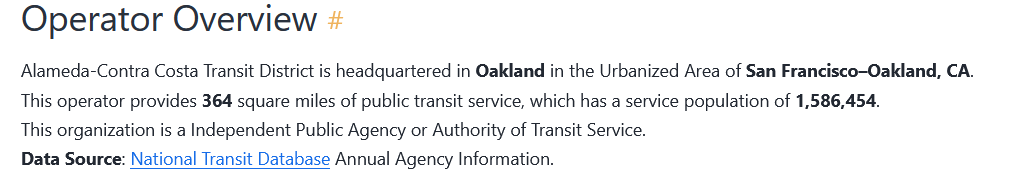

In [ ]:
crosswalk_df = merge_operator_data.concatenate_crosswalks(analysis_date_list)

In [ ]:
crosswalk_df.head(1)

In [ ]:
crosswalk_df.portfolio_organization_name.nunique(), len(
    crosswalk_df
), crosswalk_df.name.nunique()

In [ ]:
crosswalk_df.loc[crosswalk_df.service_date == "2024-01-17"].shape

In [ ]:
crosswalk_df.loc[crosswalk_df.service_date == "2024-01-17"][
    "portfolio_organization_name"
].nunique()

In [ ]:
crosswalk_df.loc[
    (crosswalk_df.service_date == "2024-01-17")
    & (
        crosswalk_df.portfolio_organization_name
        == "Ventura County (VCTC, Gold Coast, Cities of Camarillo, Moorpark, Ojai, Simi Valley, Thousand Oaks)"
    )
]

In [ ]:
operator_df = merge_operator_data.merge_data_sources_by_operator(
    schedule_df, rt_schedule_df, crosswalk_df
)

In [ ]:
operator_df.head(1)

### Task #2: 
* Is there a short/long route, can it be flagged per date as a new column here?
* Piping the `portfolio_organization_name` goes at the end, 

In [ ]:
FILE = GTFS_DATA_DICT.schedule_tables.operator_routes

concatenate_schedule_operator_metrics_df = (
    time_series_utils.concatenate_datasets_across_dates(
        SCHED_GCS,
        FILE,
        analysis_date_list,
        data_type="gdf",
    )
    .sort_values(["schedule_gtfs_dataset_key", "service_date"])
    .reset_index(drop=True)
    .pipe(
        portfolio_utils.standardize_portfolio_organization_names,
        PORTFOLIO_ORGANIZATIONS_DICT,
    )
)

In [ ]:
concatenate_schedule_operator_metrics_df.columns

In [ ]:
concatenate_schedule_operator_metrics_df[["route_id", "route_key"]].sample(3)

In [ ]:
concatenate_schedule_operator_metrics_subset = concatenate_schedule_operator_metrics_df[
    [
        "portfolio_organization_name",
        "route_id",
        "route_length_miles",
        "service_date",
    ]
]

In [ ]:
len(concatenate_schedule_operator_metrics_subset), len(
    concatenate_schedule_operator_metrics_df
)

In [ ]:
concatenate_schedule_operator_metrics_subset = (
    concatenate_schedule_operator_metrics_subset.drop_duplicates()
)

In [ ]:
len(concatenate_schedule_operator_metrics_subset)

In [ ]:
def get_min_max(group):
    min_row = group.nsmallest(1, "route_length_miles").assign(
        long_short_route="shortest"
    )
    max_row = group.nlargest(1, "route_length_miles").assign(long_short_route="longest")
    return pd.concat([min_row, max_row])

In [ ]:
longest_shortest_route = (
    concatenate_schedule_operator_metrics_subset.groupby(
        ["service_date", "portfolio_organization_name"]
    )
    .apply(get_min_max)
    .drop(columns=["route_length_miles"])
    .reset_index(drop=True)
)

In [ ]:
len(longest_shortest_route)

In [ ]:
# longest_shortest_route.groupby(["service_date", "portfolio_organization_name"]).agg(
#    {"route_id": "nunique"}
# )

In [ ]:
longest_shortest_route.loc[
    longest_shortest_route.service_date == "2024-01-17"
].portfolio_organization_name.value_counts().head()

In [ ]:
longest_shortest_route.sample()

### Why are there extra rows popping up?

In [ ]:
#  Merge back with a left join
m1 = pd.merge(
    concatenate_schedule_operator_metrics_df,
    longest_shortest_route,
    on=["portfolio_organization_name", "route_id", "service_date"],
    how="outer",
    indicator=True,
)

In [ ]:
len(concatenate_schedule_operator_metrics_df)

In [ ]:
len(m1)

In [ ]:
m1._merge.value_counts()

In [ ]:
len(m1) - len(concatenate_schedule_operator_metrics_df)

In [ ]:
def find_percentiles(df: pd.DataFrame, col_of_interest: str) -> pd.DataFrame:
    """
    Take a column you're interested in and categorize it by row
    for each percentile group it belongs to.
    """
    # Get percentiles in objects for total vehicle.
    p25 = df[col_of_interest].quantile(0.25).astype(float)
    p50 = df[col_of_interest].quantile(0.50).astype(float)
    p75 = df[col_of_interest].quantile(0.75).astype(float)

    # Make a dataframe out of this
    percentile_data = {
        f"{col_of_interest}_percentile": [
            "25th percentile",
            "50th percentile",
            "< 75th percentile",
            "> 75th percentile",
        ],
        "percentile_group": [
            f"25 percentile (<={p25.astype(int)} miles)",
            f"26-50th percentile ({p25.astype(int) + 0.1}-{p50.astype(int)} miles)",
            f"51-75th percentile ({p50.astype(int) + 0.1}-{p75.astype(int)} miles)",
            f"76th percentile (>={p75.astype(int) + 0.1} miles)",
        ],
    }
    percentile_df = pd.DataFrame(data=percentile_data)

    def categorize_percentile(row):
        if (row[col_of_interest] > 0) and (row[col_of_interest] <= p25):
            return "25th percentile"
        elif (row[col_of_interest] > p25) and (row[col_of_interest] <= p50):
            return "50th percentile"
        elif (row[col_of_interest] > p50) and (row[col_of_interest] <= p75):
            return "< 75th percentile"
        elif row[col_of_interest] > p75:
            return "> 75th percentile"
        else:
            return "Zero"

    # Actually categorize each value for percentile
    df[f"{col_of_interest}_percentile"] = df.apply(
        lambda x: categorize_percentile(x), axis=1
    )

    # Delete out routes w/o service mile info
    df = df.loc[df[f"{col_of_interest}_percentile"] != "Zero"]

    # Merge the dataframes
    df2 = pd.merge(df, percentile_df, on=f"{col_of_interest}_percentile")
    return df2

In [ ]:
# Delete out nan route_length_miles
concatenate_schedule_operator_metrics_subset2 = (
    concatenate_schedule_operator_metrics_subset.loc[
        concatenate_schedule_operator_metrics_subset.route_length_miles.notna()
    ]
)

In [ ]:
len(concatenate_schedule_operator_metrics_subset2)

In [ ]:
percentile_df = pd.DataFrame()
for operator in list(
    concatenate_schedule_operator_metrics_subset2.portfolio_organization_name.unique()
):
    one_operator = concatenate_schedule_operator_metrics_subset2.loc[
        concatenate_schedule_operator_metrics_subset2.portfolio_organization_name
        == operator
    ]
    df = find_percentiles(one_operator, "route_length_miles")
    percentile_df = pd.concat([percentile_df, df], axis=0)

In [ ]:
len(percentile_df)

In [ ]:
percentile_df.sample(10)

In [ ]:
#  Merge back with a left join
m2 = pd.merge(
    m1,
    percentile_df.drop(columns=["route_length_miles", "route_length_miles_percentile"]),
    on=["portfolio_organization_name", "route_id", "service_date"],
    how="left",
)

In [ ]:
m2.shape

In [ ]:
m1.shape

In [ ]:
concatenate_schedule_operator_metrics_df.shape

In [ ]:
# percentile_df.groupby(["portfolio_organization_name", "percentile_group"]).agg({"route_id":"nunique"})

### Task #3: DONE.
* <i>take input produced in concatenate_operator_routes
    get counties for operator-date
    df should only be operator-date-counties_served
    use this to merge into crosswalk and replace NTD column</i>

In [ ]:
def get_counties() -> gpd.GeoDataFrame:
    """
    Load a geodataframe of the California counties.
    """
    ca_gdf = "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
    my_gdf = to_snakecase(gpd.read_file(f"{ca_gdf}"))[["county_name", "geometry"]]

    return my_gdf

In [ ]:
def counties_served_by_operator(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Join the geodataframe produced by concatenate_operator_routes
    to find which counties an operator serves.
    """
    # Subset
    gdf2 = gdf[["route_id", "service_date", "portfolio_organization_name", "geometry"]]

    # Grab counties
    ca_counties = get_counties()

    # Sjoin
    counties_served = gpd.sjoin(
        gdf2, ca_counties.to_crs(gdf.crs), how="inner", predicate="intersects"
    ).drop(columns="index_right")

    # Drop Duplicates
    counties_served2 = (
        counties_served[["service_date", "portfolio_organization_name", "county_name"]]
        .drop_duplicates()
        .sort_values(by=["county_name"])
        .reset_index(drop=True)
    )

    # Concatenate the counties using a groupby
    counties_served3 = counties_served2.groupby(
        [
            "service_date",
            "portfolio_organization_name",
        ],
        as_index=False,
    ).agg({"county_name": ",".join})

    return counties_served3

In [ ]:
counties_served_df = counties_served_by_operator(gdf)

In [ ]:
counties_served_df.head(2)

In [ ]:
crosswalk_df.sample()

In [ ]:
crosswalk_df2 = pd.merge(
    crosswalk_df,
    counties_served_df,
    how="outer",
    on=["portfolio_organization_name", "service_date"],
    indicator=True,
)

In [ ]:
crosswalk_df2._merge.value_counts()